In [18]:

%load_ext autoreload
%autoreload 2
import torch
from torch.utils.data import DataLoader
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")

from src.dvip import DVIP_Base
from src.likelihood import Gaussian
from src.generative_functions import SimplerBayesLinear
from src.layers_init import init_layers
from utils.dataset import CO2_Dataset
from utils.metrics import MetricsRegression
from utils.pytorch_learning import fit, predict, score


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
params = {"vip_layers": [1],
        "genf": "BNN",
        "regression_coeffs": 20,
        "bnn_structure": [10, 10],
        "bnn_layer": SimplerBayesLinear,
        "activation": torch.tanh,
        "device": "cpu",
        "dtype": torch.float64,
        "seed": 2147483647,
        "fix_prior_noise": True,
        "genf_full_output": False,
        "final_layer_mu": 0,
        "inner_layers_mu": 0,
        "final_layer_sqrt": 1,
        "inner_layers_sqrt": 1e-5,
        "inner_layers_noise": -5,
        "final_layer_noise": None,
        "dropout": 0.0,
        "prior_kl": False,
        "zero_mean_prior": False,
        "input_prop": True,
}

In [20]:

torch.manual_seed(params["seed"]);

In [21]:
dataset = CO2_Dataset()
split = 0
train_dataset, train_test_dataset, test_dataset = dataset.get_split(split = 0)

Number of samples:  458
Input dimension:  1
Label dimension:  1
Labels mean value:  [[358.61338428]]
Labels standard deviation:  [[34.25394257]]


In [22]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
train_test_loader = DataLoader(train_test_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [23]:
layers = init_layers(train_dataset.inputs, dataset.output_dim, **params)


Layer 0: 1->1 MF: None


In [24]:
likelihood = Gaussian(dtype = params["dtype"], device = params["device"])

In [25]:
dvip = DVIP_Base(
    likelihood,
    layers,
    len(train_dataset),
    bb_alpha=0,
    num_samples=1,
    y_mean=train_dataset.targets_mean,
    y_std=train_dataset.targets_std,
    dtype=params["dtype"],
    device=params["device"]
)

In [26]:
# Define optimizer and compile model
opt = torch.optim.Adam(dvip.parameters(), lr=0.001)


fit(
    dvip,
    train_loader,
    opt,
    iterations=10000,
    device=params["device"],
)


In [27]:
metrics = MetricsRegression

In [28]:
# Set the number of test samples to generate
dvip.num_samples = 200

# Test the model
test_metrics = score(dvip, test_loader, metrics, device=params["device"])

print("TEST RESULTS: ")
for k, v in test_metrics.items():
    print("\t - {}: {}".format(k, v))

TEST RESULTS: 
	 - LOSS: -102.01837158203125
	 - RMSE: 2.2055509090423584
	 - NLL: 2.2676072120666504
	 - CRPS: 1.290895938873291


TEST RESULTS: 
	 - LOSS: -102.01837158203125
	 - RMSE: 2.2055509090423584
	 - NLL: 2.2676072120666504
	 - CRPS: 1.290895938873291


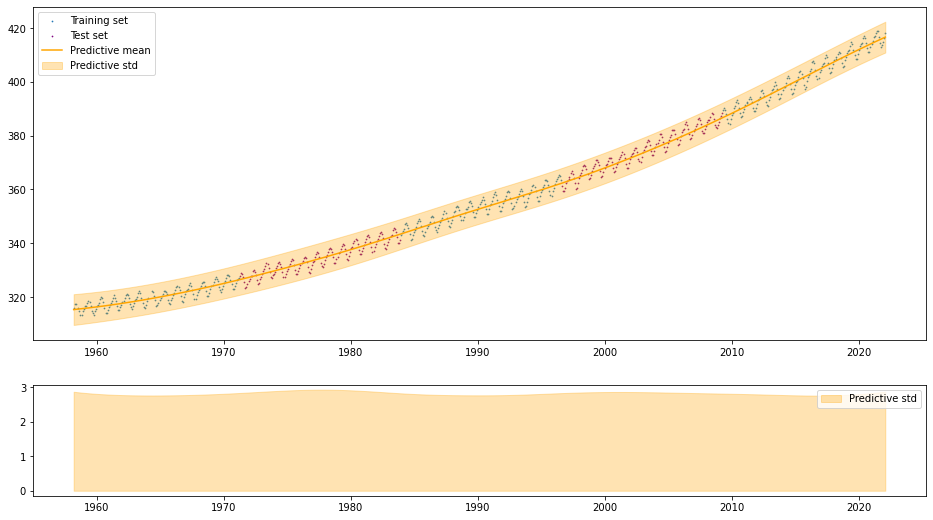

In [33]:

def get_predictive_results(mean, var):

    prediction_mean = np.mean(mean, axis=0)
    prediction_var = np.mean(var + mean ** 2, axis=0) - prediction_mean ** 2
    return prediction_mean, prediction_var


# Change MC samples for test
dvip.num_samples = 100
test_metrics = score(dvip, test_loader, metrics, device=params["device"])

test_metrics_names = list(test_metrics.keys())
num_metrics = len(test_metrics_names)

print("TEST RESULTS: ")
for k, v in test_metrics.items():
    print("\t - {}: {}".format(k, v))
    
    
test_mean, test_std = predict(dvip, train_test_loader, device=params["device"])
test_prediction_mean, test_prediction_var = get_predictive_results(test_mean, test_std**2)

import matplotlib.pyplot as plt

f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(16, 9))

ax0.scatter(train_dataset.inputs * train_dataset.inputs_std + train_dataset.inputs_mean, 
            train_dataset.targets* train_dataset.targets_std + train_dataset.targets_mean,
            s = 0.5,
            label = "Training set")
ax0.scatter(test_dataset.inputs * train_dataset.inputs_std + train_dataset.inputs_mean, 
            test_dataset.targets,
            s = 0.5,
            color = "purple",
            label = "Test set")

X = train_test_dataset.inputs* train_dataset.inputs_std + train_dataset.inputs_mean
ax0.plot(X,
         test_prediction_mean,
         color = "orange",
         label = "Predictive mean")
ax0.fill_between(X.flatten(),
                 (test_prediction_mean - 2*np.sqrt(test_prediction_var)).flatten(),
                 (test_prediction_mean + 2*np.sqrt(test_prediction_var)).flatten(),
                 color = "orange",
                 alpha = 0.3,
                 label = "Predictive std")

ymin, ymax = ax0.get_ylim()

ax0.set_ylim([ymin, ymax])
ax0.legend()

ax1.fill_between(X.flatten(),
                 np.zeros_like(X.flatten()),
                 (np.sqrt(test_prediction_var)).flatten(),
                 color = "orange",
                 alpha = 0.3,
                 label = "Predictive std")
ax1.legend()
plt.show()